#### 2021-04-14b Exposure counts towards the bulge, weighted by TRILEGAL stellar density ##

**2021-04-14:** Many cells pasted from the bulgeExtinction notebook, but with a different emphasis. Perhaps after the SCOC deadline we can simplify the important cells into .py methods, for the moment I'm literally pasting in cells...

In [140]:
# where are we?
import os
print(os.getcwd())

/home/jail/dlusers/wiclarks/testNotebooks


In [141]:
%matplotlib inline
# some standard pieces
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os, glob # for checking existence of db

In [142]:
# set up for lsst
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import lsst.sims.maf.maps as maps
# need a different set of utils for the stellarmags
import lsst.sims.utils as sims_utils



### Method to return the counts metric values ###

In [143]:
def evaluateBundleGroup(pathOpsim='DUMMY', outDir='counts_test', nside=64, timeCut=20., \
                  doPlots=False, run_name='', nightMax=10000):
    
    """Creates and evaluates the bundle group for a particular run"""
    
    if len(pathOpsim) < 1:
        return None
    
    if not os.access(pathOpsim, os.R_OK):
        return None
    
    # if a run name was not supplied, make one up by parsing the path to the opsim
    if len(run_name) < 1:
        run_name = pathOpsim.split('/')[-1].split('.db')[0]   
        
        # we DO want the _v because it separates the baselines from each other.
        #.split('_v')[0]
            
    print("####### INFO - run name:", run_name)
    
    bundleList = []
    
    # declare a few things
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [metrics.MedianMetric()]
    plotDict = {}
    plotFuncs = [plots.HealpixSkyMap()]
    resultsDb = db.ResultsDb(outDir=outDir)
    
    # Now we define the bundles for the four types: short+saturation, short+m5, long+saturation, long+m5
    sqlLong = 'visitExposureTime > %.1f and night < %i' % (timeCut, nightMax)


    # Add a counts metric for the long exposures
    metricCounts = metrics.CountMetric('visitExposureTime')
    bundleList.append(metricBundles.MetricBundle(metricCounts,slicer,sqlLong,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))
    
    
    # actually run things
    conn = db.OpsimDatabase(pathOpsim)
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    
    if doPlots:
        bg.plotAll(closefigs=False)
    
    # returns the bundlegroup
    return bg
    

### Set paths to opsims ###

In [144]:
# paths to opsims
lBaseline = glob.glob('/sims_maf/fbs_1.7/baseline/*db')
lUheavy = glob.glob('/sims_maf/fbs_1.7/u_long/*50*db')

lPaths = [lBaseline[-1]] + lUheavy  # for testing

# Here is a more comprehensive list for running on a few opsims:
lFootprint = ['/sims_maf/fbs_1.7/footprint_tune/footprint_6_v1.710yrs.db', \
              '/sims_maf/fbs_1.7/footprint_tune/footprint_8_v1.710yrs.db']
#lDust = ['/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db']
# lBulge = ['/sims_maf/fbs_1.5/bulge/bulges_i_heavy_v1.5_10yrs.db']
lBulge = glob.glob('/sims_maf/fbs_1.5/bulge/bu*.db')
lSeeing = ['/sims_maf/fbs_1.5/goodseeing/goodseeing_gi_v1.5_10yrs.db']
lFilterDist = glob.glob('/sims_maf/fbs_1.5/filter_dist/filterdist_indx?_v1.5_10yrs.db')
#lRolling = ['/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db']
lSmooth = ['/sims_maf/fbs_1.5/footprints/footprint_gp_smoothv1.5_10yrs.db']

# 1.7.1 use a different baseline. So we make a separate list...
lRolling = glob.glob('/sims_maf/fbs_1.7.1/new_rolling/*db')

# increasing WFD footprint WITHOUT increasing coverage of the bulge (v1.5)
lSky = ['/sims_maf/fbs_1.5/footprints/footprint_big_wfdv1.5_10yrs.db']

lBaseline1p5 = ['/sims_maf/fbs_1.5/baseline/baseline_v1.5_10yrs.db']

# We arrange these into v1.5 and v1.7 comparisons. We work out how to add the 
# divider into the figure later.
l1p7 = lBaseline[::-1] + lFootprint + lUheavy
l1p71 = lRolling
l1p5 = lBaseline1p5 + lBulge + lSeeing + lFilterDist + lSmooth + lSky

# uncomment this line if you want to run on a more extensive set of runs
# lPaths = lBaseline + lUheavy + lFootprint + lDust + lBulge + lSeeing + lFilterDist + lRolling + lSmooth

lPaths = l1p7 + l1p71 + l1p5

print(lPaths)
# print(l1p71)

print(len(lPaths))

['/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db', '/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db', '/sims_maf/fbs_1.7/footprint_tune/footprint_6_v1.710yrs.db', '/sims_maf/fbs_1.7/footprint_tune/footprint_8_v1.710yrs.db', '/sims_maf/fbs_1.7/u_long/u_long_ms_50_v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/baseline_nexp2_v1.7.1_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/footprint_6_v1.7.1_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/rolling_nm_scale0.90_nslice3_f

### Spatial selection for bulge region ###

In [145]:
# we need nside
nside=64

In [146]:
## Pasted from a previous notebook ##
from astropy.coordinates import SkyCoord
import astropy.units as u

# Assign each healpix a Galactic coordinate...
ipix = np.arange(hp.nside2npix(nside))
ra, dec = hp.pix2ang(nside, ipix, nest=False, lonlat=True)
coo = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')
l = coo.galactic.l.deg
b = coo.galactic.b.deg
l[l > 180.] -= 360.

# ... and set a boolean by region
bROI = np.repeat(False, np.size(l))

# Let's try the zone of avoidance from maf's "_plot_mwZone" as a starting
# point, with approximate disk and bulge cutoff regions included.
peakWidth=np.radians(8.)
taperLength=np.radians(80.)
diskThickDeg = 5.
lBulgeMin = -20
lBulgeMax = 20


val = peakWidth * np.cos(np.radians(l) / taperLength * np.pi / 2.)
inBulge = (np.abs(np.radians(b)) <= val)
inDisk = (np.abs(b) < diskThickDeg) & (np.abs(np.radians(l)) < taperLength)
inLongitude = (l > lBulgeMin) & (l < lBulgeMax)

inROI = (inBulge) | (inDisk)
inROI = (inROI) & (inLongitude)


In [147]:
# uncomment this to see the selection region the above parameters produce 
#
#hp.mollview(inROI, coord=['C','G'], cmap='viridis_r')
#hp.graticule()

## Methods to import the stellar density map for weighting ##

In [148]:
# import stellar density map - helps when scaling by nstars.
from lsst.utils import getPackageDir

def loadStarDens(sfilt='r', nside=64, wdstars='', trilegal=False, dustonly=False):
    
    """Loads the stellar density maps. nside not equal to 64 will only work if those paths exist on the system.
    
    For star maps, use wdstars='_wdstars' to retrieve white dwarfs"""
    
    # trilegal is now sent in as a boolean (so that we can use the same boolean when calling other
    # routines to reorder trilegal if necessary)
        
    # This at least supports getting the contents of star maps from different subdirectories.
    mapDir = getPackageDir('sims_maps')
    
    # We'll use glob to search for file paths matching the search string. This might be 
    # overkill (since at the moment the search strings ARE the paths we want) but it does
    # ensure we either get a readable path or no path.
    
    # search string for the map file. Default to starmaps.
    subdir='StarMaps'
    srchTail = 'starDensity_%s%s_nside_%i.npz' % (sfilt, wdstars, nside)
    
    if trilegal:
        subdir = 'TriMaps'
        srchTail = 'TRIstarDensity_%s_nside_%i.npz' % (sfilt, nside)
    
    if dustonly:
        subdir = 'DustMaps'
        srchTail = 'dust_nside_%i.npz' % (nside)
    
    # search for map file
    srchString = '%s/%s/%s' % (mapDir, subdir, srchTail)
    
    lPaths = glob.glob(srchString)
    if len(lPaths) < 1:
        print("loadStarDens WARN - no paths match string %s" % (srchString))
        return np.array([])
    
    print('getStarDens: loading path %s' % (lPaths[0]))
    starmap = np.load(lPaths[0])
    
    return starmap

In [149]:
def rotateHealpix(hpmap, transf=['C','G'], phideg=0., thetadeg=0.):
    
    """Rotates healpix map from one system to the other. Returns reordered healpy map. 
    Healpy coord transformations are used, or you can specify your own angles in degrees.
    To specify your own angles, ensure that transf has length != 2."""
    
    # For reasons I don't understand, entering in ['C', 'G'] seems to do the 
    # transformation FROM galactic TO equatorial. Possibly something buried in
    # the conventions used by healpy.
    
    # Heavily influenced by stack overflow solution here: 
    # https://stackoverflow.com/questions/24636372/apply-rotation-to-healpix-map-in-healpy
    
    nside = hp.npix2nside(len(hpmap))
    
    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    
    # Define a rotator
    if len(transf) == 2:
        r = hp.Rotator(coord=transf)
    else:
        r = hp.Rotator(deg=True, rot=[phideg,thetadeg])
    
    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    
    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hpmap, trot, prot)
    
    return rot_map


In [150]:
def getStarDens(starmap=None, maglim=24., isNested=False, isGalacs=False):
    
    """Given a star map and a limiting magnitude, returns the map value - all over the sky - at 
    that magnitude limit, as well as the magnitude limit actually used. (Currently does not 
    interpolate over magnitudes, but instead just uses the nearest bin.)"""
    
    # isNested = flag to trigger reordering from nested to ring
    
    if starmap is None:
        print("getStarDens WARN - starmap empty")
        return np.array([]), -99.
    
    # for the moment, just find the nearest bin upper edge to the bin, and select that plane of the map
    binFloors = starmap['bins']
    planeNearest = np.argmin(np.abs(binFloors-maglim))
    
    # the bin- and values-arrays are one off in size
    if planeNearest < 1:
        planeNearest = 1.
    
    magFloor = binFloors[planeNearest]
    hpvalues = starmap['starDensity'][:,planeNearest]
    
    # reorder to ring if given nested
    if isNested:
        values = np.copy(hpvalues)
        hpvalues = hp.reorder(values, n2r=True)
    
    # if given in galactic coords, use our rotator to interpolate to equatorial
    if isGalacs:
        hpvalues = rotateHealpix(hpvalues)
    
    # make hpvalues a masked array
    hpmasked = np.ma.masked_less_equal(hpvalues, 0.)
        
    return hpmasked, magFloor  

### Loading stellar density map ###

2021-03-25: On Datalab (haven't checked sciserver yet) the Trilegal map is NESTED (starDensity is RING) and is in Galactic coordinates (starDensity is in Equatorial). The method **rotateHealpix** above takes care of this, and the **getStarDens** handles the reordering from NESTED to RING. Note that **starmap** is not yet reordered, so for the Trilegal starmaps the **starmap** and **stardens** will have different orderings. That's OK for the moment since we only need stardens for what comes next.

In [151]:
# Get the stellar density. Keep the filter as a variable so we know later on what density we used.
filtDens = 'r'
magnDens = 22.
isTrilegal = True

starmap = loadStarDens(filtDens, trilegal=isTrilegal) 
stardens, magdens = getStarDens(starmap, magnDens, isNested=isTrilegal, isGalacs=isTrilegal)

getStarDens: loading path /data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maps/2017.05.08-12-gc32f352/TriMaps/TRIstarDensity_r_nside_64.npz


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/pyth

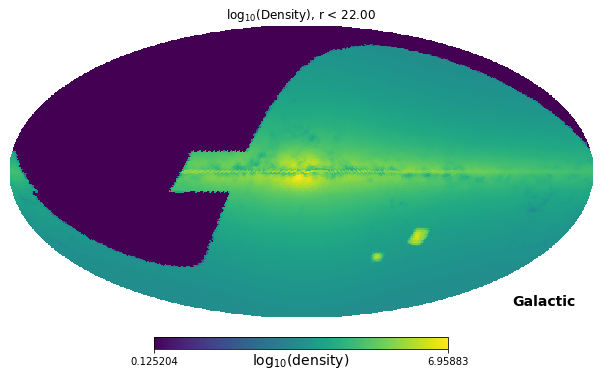

In [152]:
# show this
stardensShow = np.ma.copy(stardens)
stardensShow[stardensShow.mask] = np.ma.min(stardensShow)
hp.mollview(np.log10(stardensShow), unit=r'log$_{10}$(density)', title=r'log$_{10}$(Density), %s < %.2f' % (filtDens, magdens), 
           coord=['C','G'], norm='linear')

### Set paths to opsims ###

In [153]:
# paths to opsims
lBaseline = glob.glob('/sims_maf/fbs_1.7/baseline/*db')
lUheavy = glob.glob('/sims_maf/fbs_1.7/u_long/*50*db')

lPaths = [lBaseline[-1]] + lUheavy  # for testing

# Here is a more comprehensive list for running on a few opsims:
lFootprint = ['/sims_maf/fbs_1.7/footprint_tune/footprint_6_v1.710yrs.db', \
              '/sims_maf/fbs_1.7/footprint_tune/footprint_8_v1.710yrs.db']
#lDust = ['/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db']
# lBulge = ['/sims_maf/fbs_1.5/bulge/bulges_i_heavy_v1.5_10yrs.db']
lBulge = glob.glob('/sims_maf/fbs_1.5/bulge/bu*.db')
lSeeing = ['/sims_maf/fbs_1.5/goodseeing/goodseeing_gi_v1.5_10yrs.db']
lFilterDist = glob.glob('/sims_maf/fbs_1.5/filter_dist/filterdist_indx?_v1.5_10yrs.db')
#lRolling = ['/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db']
lSmooth = ['/sims_maf/fbs_1.5/footprints/footprint_gp_smoothv1.5_10yrs.db']

# increasing WFD footprint WITHOUT increasing coverage of the bulge (v1.5)
lSky = ['/sims_maf/fbs_1.5/footprints/footprint_big_wfdv1.5_10yrs.db']

# altsched
lAlt = ['/sims_maf/fbs_1.5/alt_roll_dust/alt_dust_v1.5_10yrs.db']


# 1.7.1 use a different baseline. So we make a separate list...
lRolling = glob.glob('/sims_maf/fbs_1.7.1/new_rolling/*db')



lBaseline1p5 = ['/sims_maf/fbs_1.5/baseline/baseline_v1.5_10yrs.db']

# We arrange these into v1.5 and v1.7 comparisons. We work out how to add the 
# divider into the figure later.
l1p7 = lBaseline[::-1] + lFootprint + lUheavy
l1p71 = lRolling
l1p5 = lBaseline1p5 + lBulge + lSeeing + lFilterDist + lSmooth + lSky + lAlt

# uncomment this line if you want to run on a more extensive set of runs
# lPaths = lBaseline + lUheavy + lFootprint + lDust + lBulge + lSeeing + lFilterDist + lRolling + lSmooth

lPaths = l1p7 + l1p71 + l1p5

print(lPaths)
# print(l1p71)

print(len(lPaths))

['/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db', '/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db', '/sims_maf/fbs_1.7/footprint_tune/footprint_6_v1.710yrs.db', '/sims_maf/fbs_1.7/footprint_tune/footprint_8_v1.710yrs.db', '/sims_maf/fbs_1.7/u_long/u_long_ms_50_v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/baseline_nexp2_v1.7.1_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/footprint_6_v1.7.1_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/rolling_nm_scale0.90_nslice3_f

In [154]:
### Try retrieving one counts metric and plotting it ###

In [155]:
# Dictionary for the exposure counts, ordered list of run names
dCounts = {}
lRuns = []

# Since we're doing everything in a single loop, we can dump the figures of merit as we go.

# Language that our plotter expects:
runnames = []
fomsOK = []
fomsGood = []
fomsCountsDens = []

nOK = 80
nGood = 180

# how many paths do we go through?
for iPath in range(len(lPaths)):

    bgroup = evaluateBundleGroup(lPaths[iPath], doPlots=False)

    # There's only one key here, so just take the values:
    keyCounts = list(bgroup.bundleDict.keys())[0]
    thisDict = bgroup.bundleDict[keyCounts]
    count = thisDict.metricValues
    runname = thisDict.runName
    
    # exposure count, booleans for whether the healpix would be classified "good" or "OK"
    dCounts[runname] = {}
    dCounts[runname]['counts'] = thisDict.metricValues
    dCounts[runname]['bOK'] = thisDict.metricValues >= nOK
    dCounts[runname]['bGood'] = thisDict.metricValues >= nGood

    # compute the figure of merit for the 'OK' fields
    densOK = dCounts[runname]['bOK'] * stardens
    densOK.mask = (densOK.mask) | (~inROI) # mask out healpix NOT in the region of interest
    sumOK = np.ma.sum(densOK)

    # compute the figure of merit for the 'Good' fields. (Yes, we could consolidate into methods)
    densGood = dCounts[runname]['bGood'] * stardens
    densGood.mask = (densGood.mask) | (~inROI) # mask out healpix NOT in the region of interest
    sumGood = np.ma.sum(densGood)

    # now let's do nexp x nstars (without hte judgement of good or ok)
    maCounts = np.ma.copy(thisDict.metricValues)
    maCounts.mask = (maCounts.mask) | (~inROI)
    sumDens = np.ma.sum(maCounts * stardens)
    
    dCounts[runname]['sumCountsDens'] = sumDens
    
    # pass to the results dictionary
    dCounts[runname]['densOK'] = densOK
    dCounts[runname]['densGood'] = densGood
    dCounts[runname]['fomOK'] = sumOK
    dCounts[runname]['fomGood'] = sumGood

    lRuns.append(runname)
    
    # Pass to the results lists
    runnameShort = '_'.join(runname.split('_')[0:4]).split('.db')[0]
    runnames.append(runnameShort)
    
    fomsOK.append(sumOK)
    fomsGood.append(sumGood)
    fomsCountsDens.append(sumDens)

####### INFO - run name: baseline_nexp2_v1.7_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint visitExposureTime > 20.0 and night < 10000 for columns ['fieldRA', 'fieldDec', 'visitExposureTime']
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_Count_visitExposureTime_visitExposureTime_gt_20_0_and_night_lt_10000_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: baseline_nexp1_v1.7_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint visitExposureTime > 20.0 and night < 10000 for columns ['fieldRA', 'fieldDec', 'visitExposureTime']
Found 2208619 visits
Running:  ['baseline_nexp1_v1_7_10yrs_Count_visitExposureTime_visitExposureTime_gt_20_0_and_night_lt_10000_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Compl

In [156]:
foms = np.copy(np.array(fomsCountsDens))

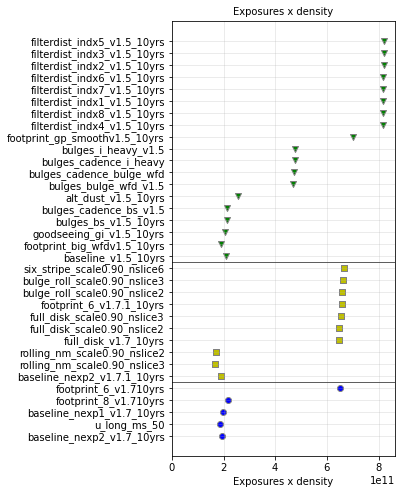

In [157]:
# OK now we have our figures of merit. Let's try plotting them as per Peter's Lots_of_runs.ipynb, 
# with a few tweaks. There's probably a way to make this more pythonic: I just copied and pasted
# the same code with arguments reversed for the moment...

# Sort each group by figure of merit value?
sortByFom = True

# Orientation of the plot
namesAcrossBottom = False

# lower axis at zero? (Set to 0 to use 0, or None to use the autoscale
# lowerLim = None
lowerLim = 0.

figsize = [8,4]
if not namesAcrossBottom:
    figsize = figsize[::-1]

    
fig1 = plt.figure(1, figsize=figsize)
ax1 = fig1.add_subplot(111)
x = np.arange(len(runnames))

fig1.set_size_inches(figsize[0], figsize[1], forward=True)

# Format handles
from matplotlib.ticker import ScalarFormatter
c_formatter = ScalarFormatter(useOffset=False)

# Partition into groups by baseline
x1p7  = x[len(l1p7)]-0.5
x1p71 = x1p7 + len(l1p71) 

# I think the best way to handle this is to treat the 
# three branches as separate arrays so we can argsort 
# and plot separately. So:
b1p7 = x < x1p7
b1p71 = (x > x1p7) & (x < x1p71)
b1p5 = (x > x1p71)

# we turn these into lists we can iterate through:
lSets = [b1p7, b1p71, b1p5]
syms = ['o', 's', 'v']
colos = ['b', 'y', 'g']
fomsA = np.array(foms)

# We need to ensure the run names are also constructed in order. This is a 
# little awkward. We create a numpy array to hold the names, and construct
# it piece by piece as with the figures of merit.
runnamesA = np.array(runnames)
runnamesSho = np.array([])

for iSet in range(len(lSets)):
    bThis = lSets[iSet]
    
    # are we sorting by fom value?
    if not sortByFom:
        if namesAcrossBottom:
            dum = ax1.scatter(x[bThis], fomsA[bThis], edgecolor='0.5', marker=syms[iSet], c=colos[iSet])
        else:
            dum = ax1.scatter(fomsA[bThis], x[bThis], edgecolor='0.5', marker=syms[iSet], c=colos[iSet])
        runnamesSho = np.hstack((runnamesSho, runnamesA[bThis] ))
        continue
        
    # otherwise, sort by figure of merit.
    xThis = np.copy(x[bThis])
    fThis = np.copy(fomsA[bThis])
    nThis = np.copy(runnamesA[bThis])
    
    lSort = np.argsort(fThis[1::])
    fSho = np.hstack(( fThis[0], fThis[1::][lSort]))
    runnamesSho = np.hstack((runnamesSho, nThis[0], nThis[1::][lSort]))
    
    if namesAcrossBottom:
        dum = ax1.scatter(xThis, fSho, edgecolor='0.5', marker=syms[iSet], color=colos[iSet])
    else:
        dum = ax1.scatter(fSho, xThis, edgecolor='0.5', marker=syms[iSet], color=colos[iSet])
        
    
# construct condition string for the title
sTitle = 'Exposures x density'
#sTitle = r'Volume for which'
#for sfilt, precis in zip(lFilters, lUnctys):
#    sTitle = r'%s $\sigma$(%s) $\leq$ %.2f &' % (sTitle, sfilt, precis)
#sTitle = sTitle[0:-1]
ax1.set_title(sTitle, fontsize=10)  # conditions label from above

# let's set the suptitle so that the string will fit across the figure
# fig1.suptitle(sTitle, fontsize=11)  # conditions label from above


#dum = ax1.scatter(x, foms, edgecolor='0.5', zorder=2)

# label
sLabel = 'Exposures x density'

if namesAcrossBottom:
    ax1.yaxis.set_major_formatter(c_formatter)
    ax1.set_ylabel(sLabel)
    ack = plt.xticks(x, runnamesSho, rotation=90)

    for xDivide in [x1p7, x1p71]:
        blah = ax1.axvline(xDivide, color='0.5', ls='-', alpha=0.7)

    #ax1.set_ylim(bottom=0., top=np.max(foms)*1.05)
    ax1.set_ylim(top=np.max(foms)*1.05)

else:
    
    ax1.xaxis.set_major_formatter(c_formatter)
    ax1.set_xlabel(sLabel)
    ack = plt.yticks(x, runnamesSho, rotation=0)

    for xDivide in [x1p7, x1p71]:
        blah = ax1.axhline(xDivide, color='0.3', ls='-', alpha=0.9, lw=1)

    #ax1.set_xlim(left=0., right=np.max(foms)*1.05)
    ax1.set_xlim(lowerLim, np.max(foms)*1.05)
    #ax1.set_xlim(right=np.max(foms)*1.05)
    
dum2 = ax1.grid(which='both', alpha=0.3, zorder=1)

# save the figure
fig1.savefig('fom_nexp_times_density.png')

In [158]:
# these are identical, as we might have expected. No real need to plot this up at this point!

In [159]:
# hp.mollview(goodScaled, coord=['C','G'])